<a id='Top'></a>

# Hidden representations<a class='tocSkip'></a>

Visualize hidden representations learned by MultiSurv.

In [1]:
%load_ext autoreload
%autoreload 2

%load_ext watermark

import sys
import os

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from cycler import cycler
import torch
from sklearn.manifold import TSNE
from lifelines import KaplanMeierFitter

# Make modules in "src" dir visible
project_dir = os.path.split(os.getcwd())[0]
if project_dir not in sys.path:
    sys.path.append(os.path.join(project_dir, 'src'))

import dataset
from model import Model
import utils

matplotlib.style.use('multisurv.mplstyle')

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#DataLoader" data-toc-modified-id="DataLoader-1"><span class="toc-item-num">1&nbsp;&nbsp;</span><code>DataLoader</code></a></span></li><li><span><a href="#Feature-representations" data-toc-modified-id="Feature-representations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Feature representations</a></span></li><li><span><a href="#2-D-embedding" data-toc-modified-id="2-D-embedding-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>2-D embedding</a></span></li><li><span><a href="#Individual-cancer-types" data-toc-modified-id="Individual-cancer-types-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Individual cancer types</a></span><ul class="toc-item"><li><span><a href="#Selected-cancers" data-toc-modified-id="Selected-cancers-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Selected cancers</a></span></li><li><span><a href="#Selected-cancer-survival-curves" data-toc-modified-id="Selected-cancer-survival-curves-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Selected cancer survival curves</a></span><ul class="toc-item"><li><span><a href="#Model-predictions" data-toc-modified-id="Model-predictions-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>Model predictions</a></span></li></ul></li><li><span><a href="#Visualize-outlier-patients" data-toc-modified-id="Visualize-outlier-patients-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Visualize outlier patients</a></span></li><li><span><a href="#Selected-cancers-with-outliers" data-toc-modified-id="Selected-cancers-with-outliers-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Selected cancers with outliers</a></span><ul class="toc-item"><li><span><a href="#Save-to-file" data-toc-modified-id="Save-to-file-4.4.1"><span class="toc-item-num">4.4.1&nbsp;&nbsp;</span>Save to file</a></span></li></ul></li><li><span><a href="#Outlier-survival-curves" data-toc-modified-id="Outlier-survival-curves-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Outlier survival curves</a></span><ul class="toc-item"><li><span><a href="#PRAD" data-toc-modified-id="PRAD-4.5.1"><span class="toc-item-num">4.5.1&nbsp;&nbsp;</span>PRAD</a></span></li><li><span><a href="#KIRC" data-toc-modified-id="KIRC-4.5.2"><span class="toc-item-num">4.5.2&nbsp;&nbsp;</span>KIRC</a></span></li><li><span><a href="#OV" data-toc-modified-id="OV-4.5.3"><span class="toc-item-num">4.5.3&nbsp;&nbsp;</span>OV</a></span></li><li><span><a href="#GBM" data-toc-modified-id="GBM-4.5.4"><span class="toc-item-num">4.5.4&nbsp;&nbsp;</span>GBM</a></span></li></ul></li><li><span><a href="#Check-survival-times" data-toc-modified-id="Check-survival-times-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Check survival times</a></span></li><li><span><a href="#All-others" data-toc-modified-id="All-others-4.7"><span class="toc-item-num">4.7&nbsp;&nbsp;</span>All others</a></span><ul class="toc-item"><li><span><a href="#Save-to-file" data-toc-modified-id="Save-to-file-4.7.1"><span class="toc-item-num">4.7.1&nbsp;&nbsp;</span>Save to file</a></span></li></ul></li></ul></li><li><span><a href="#Outlier-detection" data-toc-modified-id="Outlier-detection-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Outlier detection</a></span><ul class="toc-item"><li><span><a href="#Visualize-outliers-in-embedding" data-toc-modified-id="Visualize-outliers-in-embedding-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Visualize outliers in embedding</a></span></li><li><span><a href="#Plot-outlier-time/prediction-curve" data-toc-modified-id="Plot-outlier-time/prediction-curve-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Plot outlier time/prediction curve</a></span></li></ul></li><li><span><a href="#Exploring-other-features" data-toc-modified-id="Exploring-other-features-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Exploring other features</a></span></li></ul></div>

In [2]:
DATA = utils.INPUT_DATA_DIR
MODELS = utils.TRAINED_MODEL_DIR

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Functions<a class='tocSkip'></a>

In [3]:
PLOT_SIZE = (4, 4)
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# `DataLoader`

In [4]:
dataloaders = utils.get_dataloaders(
    data_location=DATA,
    labels_file='../data/labels.tsv',
    modalities=['clinical', 'mRNA'],
#     exclude_patients=exclude_cancers,
    return_patient_id=True
)

Data modalities:
   clinical
   mRNA

Dataset sizes (# patients):
   train: 8880
   val: 1109
   test: 1092

Batch size: 128


# Feature representations

Collect feature representations learned by MultiSurv for every patient in the test dataset.

In [5]:
multisurv = Model(dataloaders=dataloaders, device=device)
multisurv.load_weights(os.path.join(MODELS, 'clinical_mRNA_lr0.005_epoch43_acc0.81.pth'))

Instantiating MultiSurv model...
Load model weights:
/mnt/dataA/multisurv_models/clinical_mRNA_lr0.005_epoch43_acc0.81.pth


In [6]:
patient_dataset = dataloaders['test'].dataset

In [7]:
%%time

n = len(patient_dataset)
feature_representations = {'patients': [],
                           'features': {'modalities': [],
                                        'fused': []}}

print('Collect feature representations:')

for i, patient in enumerate(patient_dataset):
    print(f'{str((i + 1))}/{n}', end='\r')
    data = patient[0]
    pid = patient[3]
    feature_representations['patients'].append(pid)
    
    data, _ = multisurv.predict(data)
    for k in data:
        if k == 'fused':
            feature_representations['features'][k].append(data[k].cpu()[0])
        else:
            data_modalities = []
            for i in range(len(data[k])):
                data_modalities.append(data[k][i].cpu()[0])
            feature_representations['features'][k].append(data_modalities)
print()
print()

Collect feature representations:
1092/1092

CPU times: user 33.5 s, sys: 8.09 s, total: 41.6 s
Wall time: 1min 41s


In [8]:
feature_representations.keys()

dict_keys(['patients', 'features'])

In [9]:
feature_representations['features'].keys()

dict_keys(['modalities', 'fused'])

# 2-D embedding

Compute a 2-dimensional embedding of MultiSurv's learned hidden representation.

In [10]:
data_to_embed = feature_representations['features']['fused']

In [11]:
data_to_embed = np.stack(data_to_embed)
data_to_embed.shape

(1092, 512)

In [12]:
embedded_data = {'patients': feature_representations['patients'],
                 'embeddings': None}

In [13]:
%%time

embedded_data['embeddings'] = TSNE(
    n_components=2, perplexity=50, random_state=42,
    method='exact').fit_transform(data_to_embed)

CPU times: user 35.3 s, sys: 467 ms, total: 35.7 s
Wall time: 15.5 s


In [14]:
embedded_data['embeddings'].shape

(1092, 2)

In [15]:
def embeddings_to_pandas(data):
    labels = pd.read_csv('../data/labels.tsv', sep='\t')
#     clinical_data = pd.read_csv('../data/clinical_data.tsv', sep='\t',
#                                 na_values=['not reported', 'Not Reported'])

    embeddings = pd.DataFrame(data['embeddings'], columns=['x', 'y'])
    embeddings['submitter_id'] = data['patients']
    embeddings = embeddings.merge(labels.iloc[:, :-1])
    embeddings.set_index('submitter_id', inplace=True)
    
    return embeddings

In [16]:
embeddings = embeddings_to_pandas(data=embedded_data)
embeddings.head()

,x,y,project_id,time,event
submitter_id,,,,,
TCGA-D7-A4Z0,10.385220,6.845390,STAD,1.230137,0
TCGA-EL-A3ZQ,-48.239819,12.968749,THCA,5.101370,0
TCGA-AA-3662,15.406239,-24.419121,COAD,0.504110,0
TCGA-BH-A203,-3.036530,-15.971469,BRCA,3.216438,1
TCGA-YC-A8S6,3.212768,-1.854539,BLCA,0.802740,0


# Individual cancer types

## Selected cancers

In [66]:
def _show_patient_ids(data, plot, intervals=None, patient_ids=None,
                      annotation_offsets=None, color='k'):
    # expects "intervals" in format {'x': [min, max], 'y': [min, max]}
    def _add_label(x, y, pid, annotation_offset, color):
        # Move line a little away from point
        _, y_off = annotation_offset
        y = y + 1 if y_off > 0 else y - 1
        plot.annotate(pid, xy=(x, y), xycoords='data',
                      xytext=annotation_offset, textcoords='offset points', size=8,
                      arrowprops=dict(arrowstyle='-', color=color),
                      color=color,
            )

    for patient, columns in data.iterrows():
        if patient_ids is not None:
            if not patient in patient_ids:
                continue
        x, y = data.loc[patient].x, data.loc[patient].y
        
        if annotation_offsets is None:
            offset = (-5, 10)
        else:
            offset = annotation_offsets[patient]

        if intervals is None:
            _add_label(x, y, patient, annotation_offset=offset, color=color)
        else:
            for interval in intervals:
                if interval['x'][0] <= x <= interval['x'][1]:
                    if interval['y'][0] <= y <= interval['y'][1]:
                        _add_label(x, y, patient, annotation_offset=offset, color=color)
                        
def _despine(ax):
    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color('none')
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
    return ax

In [67]:
def scatter_plot(data, cancer_type_cm, despine=True,
                 regions_to_annotate=None, patients_to_annotate=None,
                 offset_map=None, plot_size=PLOT_SIZE):
    fig = plt.figure(figsize=plot_size)
    ax = fig.add_subplot(1, 1, 1)

    # Plot all patients
    ax.scatter(data.x, data.y, s=10, color='lightgrey', label='Others')

    # Plot patient subset for each cancer type
    for cancer_type in cancer_type_cm:
        cancer_data = data[data['project_id'] == cancer_type]
        ax.scatter(cancer_data.x, cancer_data.y, s=10,
                   color=cancer_type_cm[cancer_type], label=cancer_type)
        
        if regions_to_annotate is not None:
            _show_patient_ids(cancer_data, ax, intervals=regions_to_annotate,
                              color=cancer_type_cm[cancer_type])
        if patients_to_annotate is not None:
            _show_patient_ids(cancer_data, ax, patient_ids=patients_to_annotate,
                              annotation_offsets=offset_map, color=cancer_type_cm[cancer_type])

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

    if despine:
        ax = _despine(ax)
    
    return fig

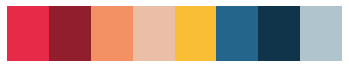

In [19]:
utils.plot.show_default_colors()

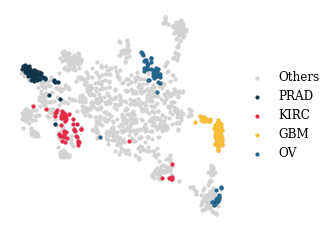

In [20]:
cancer_type_colors = {
    'PRAD': default_colors[6],
    'KIRC': default_colors[0],
    'GBM': default_colors[4],
    'OV': default_colors[5]
}

fig = scatter_plot(data=embeddings, cancer_type_cm=cancer_type_colors)

## Selected cancer survival curves

### Model predictions

Collect model predictions for all patients in the test dataset.

In [68]:
%%time

results = multisurv.predict_dataset(patient_dataset)
print()
print()

Analyzing patients
1092/1092

CPU times: user 21.3 s, sys: 4.57 s, total: 25.8 s
Wall time: 25.7 s


In [69]:
def predictions_to_pandas(data):
    labels = pd.read_csv('../data/labels.tsv', sep='\t')
#     clinical_data = pd.read_csv('../data/clinical_data.tsv', sep='\t',
#                                 na_values=['not reported', 'Not Reported'])

    predictions = np.stack([x[0] for x in data['patient_data'].values()])    
    # Add prediction 1 at time 0 (patients still alive)
    ones = np.ones((predictions.shape[0], 1))
    predictions = np.concatenate((ones, predictions), axis=1)
    
    predictions = pd.DataFrame(predictions, columns=[str(i) for i in range(predictions.shape[-1])])
    patient_ids = list(data['patient_data'].keys())
    predictions['submitter_id'] = patient_ids
    
    predictions = predictions.merge(labels.iloc[:, :-1])
    predictions.set_index('submitter_id', inplace=True)
    
    return predictions

In [70]:
predictions = predictions_to_pandas(data=results)

## Visualize outlier patients

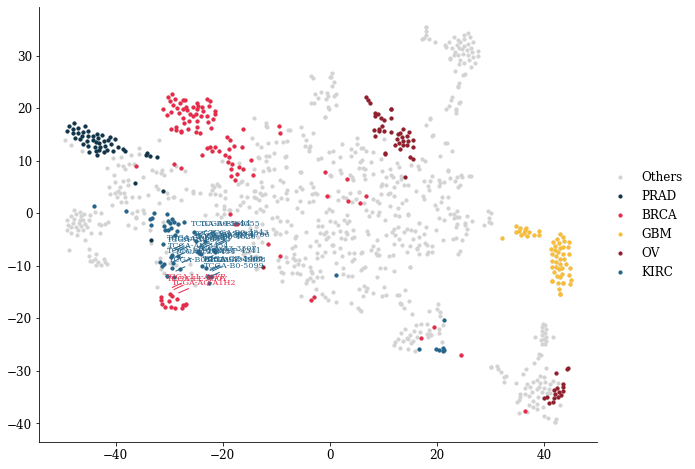

In [71]:
size = (10, 8)

cancer_type_colors = {
    'PRAD': default_colors[6],
    'BRCA': default_colors[0],
    'GBM': default_colors[4],
    'OV': default_colors[1],
    'KIRC': default_colors[5]}

fig = scatter_plot(data=embeddings, cancer_type_cm=cancer_type_colors, despine=False,
                   regions_to_annotate=[
#                        {'x': [-50, 0], 'y': [0, 100]},
                       {'x': [-30, -20], 'y': [-17, -5]},
                   ], patients_to_annotate=None, plot_size=size)

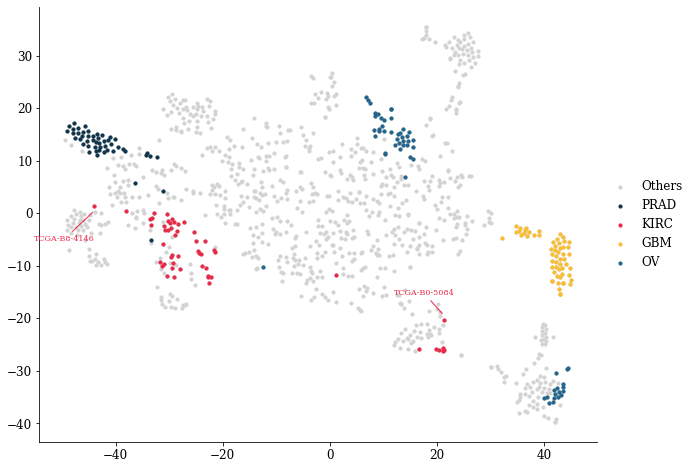

In [73]:
size = (10, 8)

cancer_type_colors = {
    'PRAD': default_colors[6],
    'KIRC': default_colors[0],
    'GBM': default_colors[4],
    'OV': default_colors[5]}

annot_offsets = {'TCGA-B8-4146': (-60, -30),
                 'TCGA-B0-5084': (-50, 20)}

fig = scatter_plot(data=embeddings, cancer_type_cm=cancer_type_colors, despine=False,
                   regions_to_annotate=None, patients_to_annotate=[
                       'TCGA-B8-4146', 'TCGA-B0-5084'], offset_map=annot_offsets,
                   plot_size=size)

---

Save temporary file to zoom in and more easily read patient IDs.

---

In [75]:
cancer_type_colors = {
    'PRAD': default_colors[6],
    'KIRC': default_colors[0],
    'GBM': default_colors[4],
    'OV': default_colors[5]
}

prediction_outlier_patients = {
    'PRAD': ['TCGA-TK-A8OK'],
    'KIRC': ['TCGA-B8-4146', 'TCGA-B0-5084'],
    'OV': ['TCGA-29-1781', 'TCGA-23-2641'],
    'GBM': ['TCGA-06-0139'],
}

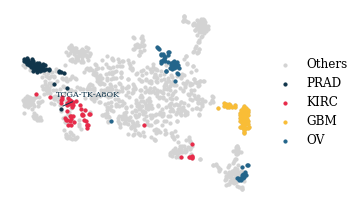

In [76]:
cancer_type = 'PRAD'

fig = scatter_plot(data=embeddings,
                   cancer_type_cm=cancer_type_colors,
#                    despine=False,
                   patients_to_annotate=prediction_outlier_patients[cancer_type],
                   plot_size=(4.5, 3.5))

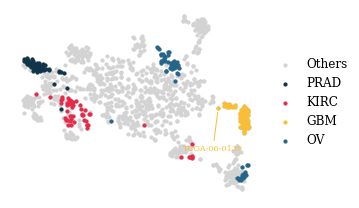

In [77]:
cancer_type = 'GBM'

annot_offsets = {prediction_outlier_patients[cancer_type][0]: (-35, -40)}

fig = scatter_plot(data=embeddings,
                   cancer_type_cm=cancer_type_colors,
#                    despine=False,
                   patients_to_annotate=prediction_outlier_patients[cancer_type],
                   offset_map=annot_offsets,
                   plot_size=(4.5, 3.5))

In [78]:
cancer_type_colors = {
    'KIRC': default_colors[0]}

prediction_outlier_patients = {
    'KIRC': [
        # Long survival
        'TCGA-B8-4146',
        # Short survival
        'TCGA-B0-5084',
    ]}

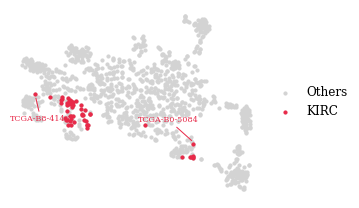

In [79]:
cancer_type = 'KIRC'

offsets = [(-25, -25), (-55, 20)]
annot_offsets = {pid: offsets[i]
                 for i, pid in enumerate(prediction_outlier_patients[cancer_type])}

fig = scatter_plot(data=embeddings,
                   cancer_type_cm=cancer_type_colors,
#                    despine=False,
                   patients_to_annotate=prediction_outlier_patients[cancer_type],
                   offset_map=annot_offsets,
                   plot_size=(4.5, 3.5))

In [80]:
cancer_type_colors = {
    'OV': default_colors[5]}

prediction_outlier_patients = {
    'OV': [
        # Long survival
        'TCGA-29-1781',
        # Short survival
        'TCGA-23-2641',
    ]}

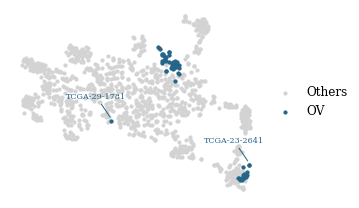

In [81]:
size = (8, 8)
cancer_type = 'OV'

offsets = [(-45, 20), (-45, 20)]
annot_offsets = {pid: offsets[i]
                 for i, pid in enumerate(prediction_outlier_patients[cancer_type])}

fig = scatter_plot(data=embeddings,
                   cancer_type_cm=cancer_type_colors,
#                    despine=False,
                   patients_to_annotate=prediction_outlier_patients[cancer_type],
                   offset_map=annot_offsets,
                   plot_size=(4.5, 3.5))

## Selected cancers with outliers

In [82]:
cancer_type_colors = {
    'PRAD': default_colors[6],
    'KIRC': default_colors[0],
    'GBM': default_colors[4],
    'OV': default_colors[5]
}

prediction_outlier_patients = {
    'PRAD': ['TCGA-TK-A8OK'],
    'KIRC': ['TCGA-B8-4146', 'TCGA-B0-5084'],
    'OV': ['TCGA-29-1781', 'TCGA-23-2641'],
    'GBM': ['TCGA-06-0139'],
}

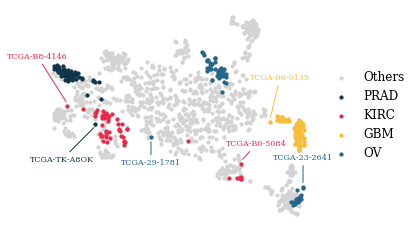

In [98]:
outliers = list(prediction_outlier_patients.values())
# Flatten list of lists
outliers = [pid for sublist in outliers for pid in sublist]

annot_offsets = {
    'TCGA-TK-A8OK': (-65, -35),
    'TCGA-B8-4146': (-60, 45),
    'TCGA-B0-5084': (-15, 15),
    'TCGA-29-1781': (-30, -25),
    'TCGA-23-2641': (-30, 25),
    'TCGA-06-0139': (-20, 40),
}

fig = scatter_plot(data=embeddings,
                   cancer_type_cm=cancer_type_colors,
#                    despine=False,
                   patients_to_annotate=outliers,
                   offset_map=annot_offsets,
#                    plot_size=(4.5, 3.5)
                   plot_size=(5, 4)
                  )

### Save to file

## Outlier survival curves

In [102]:
def custom_legend_for_patient_plot(label_color_map):
    legend_elements = []

    for k in label_color_map:
        if k != 'Others':
            marker, alpha = 'o', 1
        else:
            marker, alpha = '', 0.15

        legend_elements.append(matplotlib.lines.Line2D(
            [0], [0], color=label_color_map[k], marker=marker, alpha=alpha, label=k))

    return legend_elements

In [103]:
def annotate_follow_up_time(ax, annotation_map, color):
    text = annotation_map['text']
    xy = (annotation_map['time_point'],
          annotation_map['probability'])
    nudge = annotation_map['nudge']
    text_coords = (annotation_map['time_point'] + nudge[0],
                   annotation_map['probability'] + nudge[1])
    c = color

    ax.annotate(text, xy=xy, xytext=text_coords,
                color=c,
                bbox=dict(boxstyle='round,pad=0.1', fc='w', ec='w', alpha=0.5),
                arrowprops=dict(arrowstyle='-', color=c))

    return ax

In [104]:
def plot_selected_patient_survival(data, patient_cm, time_points,
                                   follow_up_annotations=None,
                                   plot_size=PLOT_SIZE):
    fig = plt.figure(figsize=plot_size)
    ax = fig.add_subplot(1, 1, 1)
    
    def _patient_survival(data, patient_id):
        patient_pred = data.loc[patient_id, [str(i) for i in range(31)]]

        return patient_pred.values

    for patient in data.index:
        if not patient in patient_cm:
            patient_pred = _patient_survival(data, patient)
            ax.plot(time_points[:22], patient_pred[:22],
                    linestyle='-', color=patient_colors['Others'],
                    alpha=0.1, label='Others')

        for patient in patient_cm:
            if patient != 'Others':
                ax.plot(time_points[:22], _patient_survival(data, patient)[:22],
                        marker='o', color=patient_colors[patient], label=patient)


        if follow_up_annotations is not None:
            # Draw lines at end of follow-up time
            for patient in follow_up_annotations:
                ax = annotate_follow_up_time(ax, follow_up_annotations[patient],
                                             patient_colors[patient])


    ax.set_ylim(0, 1.1)
    ax.set_xlim(None, 22)
    legend_elements = custom_legend_for_patient_plot(label_color_map=patient_cm)
    ax.legend(handles=legend_elements, loc='center left',
#               bbox_to_anchor=(1, 0.5)
              bbox_to_anchor=(0.25, 1.2))
    ax.set_title('')
    ax.set_xlabel('Time (years)')
    ax.set_ylabel('Survival probability')

    return fig

In [105]:
def make_annotation_map(patients, nudges, predictions=predictions,
                        patient_dataset=dataloaders['test'].dataset,
                        model=multisurv):
    annotation_map = {}

    for patient in patients:
        event = patient_dataset.label_map[patient][1]
        annotation_map[patient] = {
            'cancer_type': cancer_type,
            'time_point': predictions.loc[patient]['time'],
            'probability': model.predict(
                input_data=patient_dataset.get_patient_data(patient)[0],
                prediction_year=predictions.loc[patient]['time'])[1],
            'nudge': nudges[patient],
            'text': ('Last follow up' if event == 0 else 'Death')
        }
    
    return annotation_map

### PRAD

In [106]:
cancer_type = 'PRAD'

patient_colors = {
    'TCGA-TK-A8OK': cancer_type_colors[cancer_type],
    'Others': 'k'}

nudges = {'TCGA-TK-A8OK': (0, -0.5)}

follow_up_annotation_map = make_annotation_map(['TCGA-TK-A8OK'], nudges)

PRAD


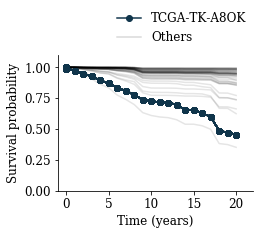

In [107]:
survival_time_points = utils.plot.format_output_intervals(multisurv.output_intervals)

print(cancer_type)

fig = plot_selected_patient_survival(
    data=predictions[predictions['project_id'] == cancer_type],
    patient_cm=patient_colors,
#     follow_up_annotations=follow_up_annotation_map,
    time_points=survival_time_points, plot_size=(3.5, 2.5))

### KIRC

In [268]:
cancer_type = 'KIRC'

patient_colors = {p: default_colors[i]
                  for i, p in enumerate(prediction_outlier_patients[cancer_type])}
patient_colors['Others'] = 'k'

nudges = {'TCGA-B8-4146': (3, -0.3), 'TCGA-B0-5084': (4, -0.25)}

follow_up_annotation_map = make_annotation_map(['TCGA-B8-4146', 'TCGA-B0-5084'], nudges)

KIRC


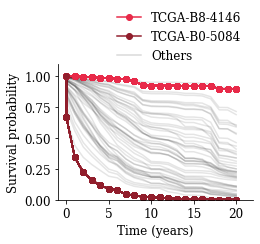

In [269]:
survival_time_points = utils.plot.format_output_intervals(multisurv.output_intervals)

print(cancer_type)

fig = plot_selected_patient_survival(
    data=predictions[predictions['project_id'] == cancer_type],
    patient_cm=patient_colors,
#     follow_up_annotations=follow_up_annotation_map,
    time_points=survival_time_points, plot_size=(3.5, 2.5))

### OV

In [272]:
cancer_type = 'OV'

patient_colors = {p: [default_colors[x] for x in [5, 6]][i]
                  for i, p in enumerate(prediction_outlier_patients[cancer_type])}
patient_colors['Others'] = 'k'

nudges = {'TCGA-29-1781': (4, 0.05), 'TCGA-23-2641': (7, 0)}

follow_up_annotation_map = make_annotation_map(['TCGA-29-1781', 'TCGA-23-2641'], nudges)

OV


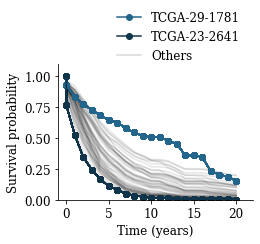

In [273]:
survival_time_points = utils.plot.format_output_intervals(multisurv.output_intervals)

print(cancer_type)

fig = plot_selected_patient_survival(
    data=predictions[predictions['project_id'] == cancer_type],
    patient_cm=patient_colors,
#     follow_up_annotations=follow_up_annotation_map,
    time_points=survival_time_points, plot_size=(3.5, 2.5))

### GBM

In [276]:
cancer_type = 'GBM'

patient_colors = {
    'TCGA-06-0139': cancer_type_colors[cancer_type],
    'Others': 'k'}

nudges = {'TCGA-06-0139': (3, 0.2)}

follow_up_annotation_map = make_annotation_map(['TCGA-06-0139'], nudges)

GBM


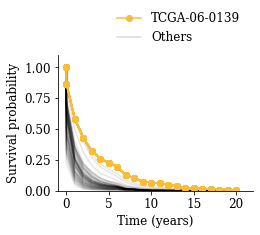

In [277]:
survival_time_points = utils.plot.format_output_intervals(multisurv.output_intervals)

print(cancer_type)

fig = plot_selected_patient_survival(
    data=predictions[predictions['project_id'] == cancer_type],
    patient_cm=patient_colors,
#     follow_up_annotations=follow_up_annotation_map,
    time_points=survival_time_points, plot_size=(3.5, 2.5))

## All others

In [109]:
all_others = [cancer for cancer in pd.read_csv('../data/labels.tsv', sep='\t').project_id.unique()
              if not cancer in cancer_type_colors]
all_others = sorted(all_others)

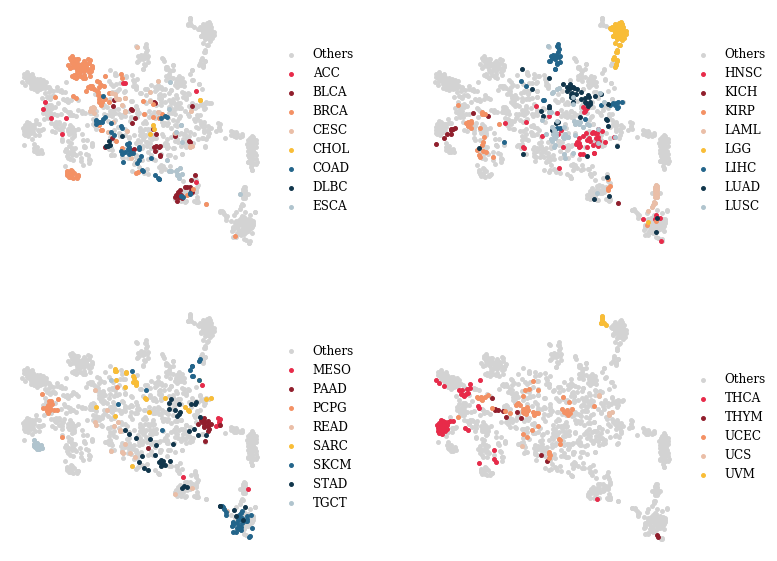

In [110]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.subplots_adjust(hspace = .2, wspace=.6)
axs = axs.ravel()

start = 0

for i in range(4):
    axs[i].set_prop_cycle(cycler('color', default_colors))
    end = 8 * (i + 1)
    
    # Plot all patients
    axs[i].scatter(embeddings.x, embeddings.y, s=15, color='lightgrey', label='Others')
    
    # Plot patient subset for current iteration's cancer types
    for cancer_type in all_others[start:end]:
        cancer_data = embeddings[embeddings['project_id'] == cancer_type]       
        axs[i].scatter(cancer_data.x, cancer_data.y, s=15, label=cancer_type)
        
    start = end  # Update start index
    
    axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    axs[i] = _despine(axs[i])

### Save to file

# Watermark<a class='tocSkip'></a>

In [8]:
%watermark --iversions
%watermark -v
print()
%watermark -u -n

matplotlib 3.1.2
numpy      1.18.1
torch      1.4.0
pandas     1.0.1

CPython 3.6.7
IPython 7.11.1

last updated: Tue Jul 28 2020


[Top of the page](#Top)